In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from numpy import fft
from numpy.fft import fftshift, fft2, ifftshift, ifft2
import scipy.signal as ss

def show_img(imagen_np, title=""):
    plt.imshow(imagen_np, cmap='gray', vmin=0, vmax=255)
    plt.title(title)
    plt.axis('off')
    plt.show()

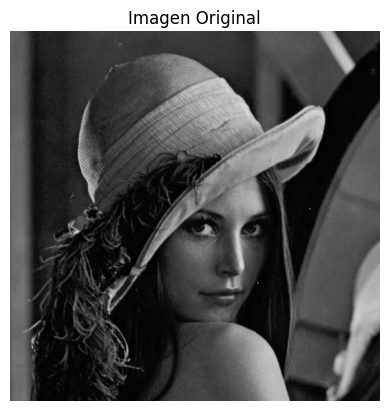

In [ ]:
img_original = cv2.imread('lena_gray.tif', cv2.IMREAD_GRAYSCALE)
show_img(img_original, title="Imagen Original")

In [ ]:
def myBlur(img, R=10):
  ancho=img.shape[1]; alto = img.shape[0]
  dist = lambda i,j: np.sqrt((i-ancho/2)**2+(j-alto/2)**2)
  kernel = np.array([[1 if dist(i,j)<R else 0 for j in range(ancho)] for i in range(alto)])
  kernel = kernel/(np.pi*R**2)
  return cv2.filter2D(img, -1, kernel), kernel

In [ ]:
# Funcion que le agrega ruido con desvio sigma a la imagen
def noise(image, std):
     return np.clip(image+np.random.normal(0, std, image.shape), 0, 255)

In [ ]:
# Calculo del MSE
MSE = lambda orig, recu: np.square(np.subtract(orig, recu)).mean()

# 1) Inverse Filtering

## a) Blur


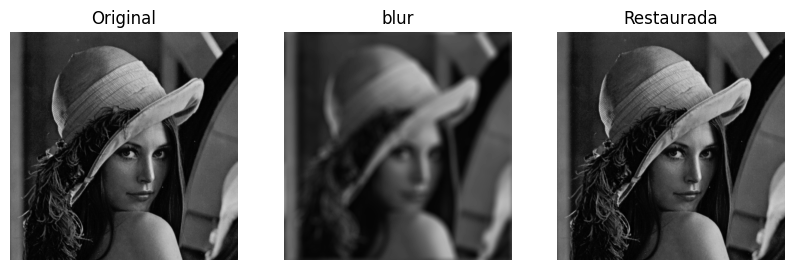

MSE con blur+noise: 292.2510455502702
MSE recuperada: 1.3824141492215957e-18


In [ ]:
image = cv2.imread('lena_gray.tif', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10,10))

# Imagen Original
plt.subplot(1,3,1)
plt.axis(False)
plt.title('Original')
plt.imshow(image, cmap='gray', vmin=0, vmax=255)

# Con blur
plt.subplot(1,3,2)
plt.axis(False)
plt.title('blur')
img_blur, filter_kernel = myBlur(image)
plt.imshow(img_blur, cmap='gray', vmin=0, vmax=255)

# Recuperada con Filtro inverso
fft_blur = np.fft.fft2(img_blur)
H_blur = np.fft.fft2(h_blur)
img_rep = np.real(fftshift(ifft2(fft_blur/(H_blur))))

plt.subplot(1,3,3)
plt.axis(False)
plt.title('Restaurada')
plt.imshow(img_rep, cmap='gray', vmin=0, vmax=255)
plt.show()

print('MSE con blur:', MSE(image, img_blur))
print('MSE recuperada:', MSE(image, img_rep))

## b) Blur + Noise

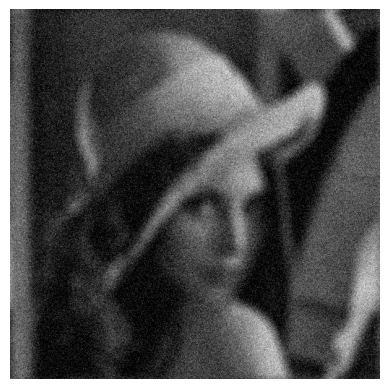

In [ ]:
std = 20
noise = np.random.normal(0, std, img_blur.shape)
img_BlurNoise = np.clip(img_blur+noise, 0, 255)
show_img(img_BlurNoise)

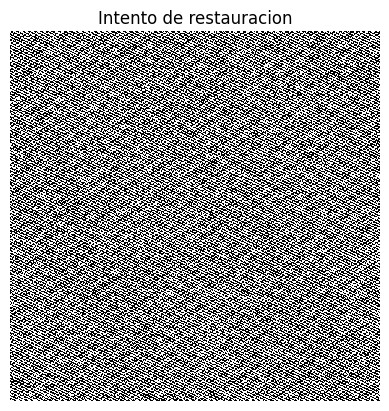

In [ ]:
fft_blur = fft2(img_BlurNoise)
H_blur = fft2(h_blur)
img_rep = np.real(fftshift(ifft2(fft_blur/(H_blur))))
show_img(img_rep, title="Intento de restauracion")

Al hacer el cociente entre la transferencia de nuestro LP y el espectro del ruido, amplificamos la potencia de ruido en altas frecuencias. Esto causa que la imagen no pueda ser recuperable con este filtro.

Si elegimos otro filtro donde la atenuación de banda de frenado sea más baja, la imagen podrá ser recuperada ya que no se atenuaría el ruido. Otra forma es aplicando algún método de regularización como se hará en la sección 5.

# 2) Wiener

In [ ]:
def wiener(image, filter_kernel, SNR):
	H = fft.fft2(filter_kernel)
	image_spect = np.fft.fft2(image)
	return np.clip(fft.fftshift(fft.ifft2(image_spect*H.conj()/(H*H.conj()+1/SNR))).real, 0, 255)

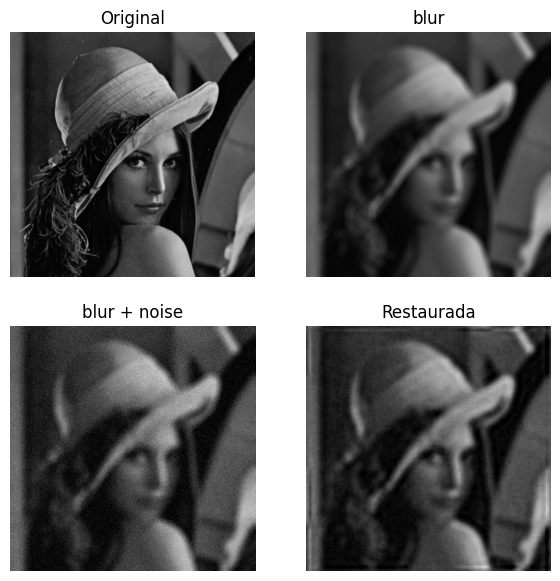

MSE con blur+noise: 453.18743115057464
MSE recuperada: 292.23377117936616


In [ ]:
image = cv2.imread('lena_gray.tif', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(7,7))

# Imagen Original
plt.subplot(2,2,1)
plt.axis(False)
plt.title('Original')
plt.imshow(image, cmap='gray', vmin=0, vmax=255)

# Con blur
plt.subplot(2,2,2)
plt.axis(False)
plt.title('blur')
image2, filter_kernel = myBlur(image)
plt.imshow(image2, cmap='gray', vmin=0, vmax=255)

# blur y noise
plt.subplot(2,2,3)
plt.title('blur + noise')
plt.axis(False)

SNR = 10  # dB

# Agregamos ruido
image3 = noise(image2, np.sqrt(np.var(image2) * (10**(-SNR/10))))
plt.imshow(image3, cmap='gray', vmin=0, vmax=255)

# Recuperada con Wiener
plt.subplot(2,2,4)
plt.axis(False)
plt.title('Restaurada')
image4 = wiener(image3, filter_kernel, 10**(SNR/10))
plt.imshow(image4, cmap='gray', vmin=0, vmax=255)
plt.show()

print('MSE con blur+noise:', MSE(image, image3))
print('MSE recuperada:', MSE(image, image4))


# 3) Blind Deconvolution

Para realizar la deconvolución ciega usamos el algoritmo de [Richardson-Lucy](https://sci-hub.se/10.1364/JOSA.62.000055) y nos basamos en su implementación realizada por [Sci-Kit](https://github.com/scikit-image/scikit-image/blob/main/skimage/restoration/deconvolution.py).

En la siguiente foto puede verse el algoritmo desarrollado donde $\hat{I}(t)$ es la predicción de la imagen, B la imagen desenfocada, K la PSF y K* el flip de la PSF.

Créditos de la imagen: [Xiaoyu Bi](https://www.youtube.com/watch?v=xPVisJXmSlg&t=157s&ab_channel=CMUComputationalPhotography)

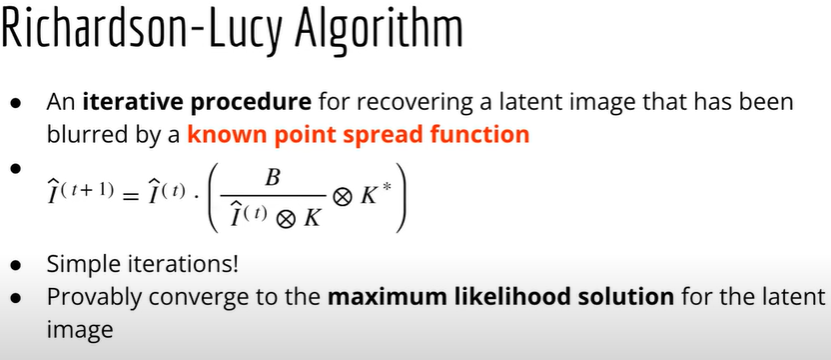


In [ ]:
def richardson_lucy(image, psf, num_iter=50):
    im_deconv = np.full(image.shape, 0.5)

    for _ in range(num_iter):
        relative_blur = image / ss.convolve(im_deconv, psf, mode='same')    # B/ (I(t)*K)
        im_deconv *= ss.convolve(relative_blur, np.flip(psf), mode='same')

    return np.clip(im_deconv,0,1)

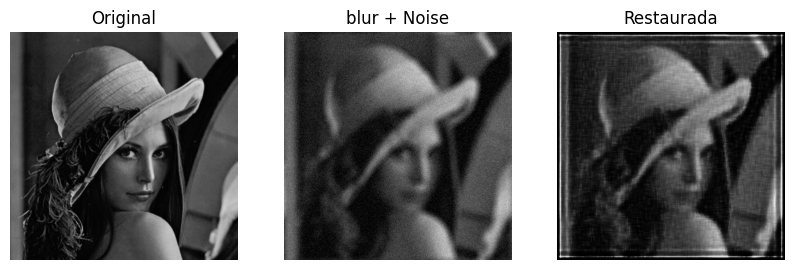

MSE con blur: 292.2510455502702
MSE recuperada: 897.5049975052181


In [ ]:
image = cv2.imread('lena_gray.tif', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10,10))

# Imagen Original
plt.subplot(1,3,1)
plt.axis(False)
plt.title('Original')
plt.imshow(image, cmap='gray', vmin=0, vmax=255)

# Con blur + Noise
img_blur, filter_kernel = myBlur(image)
SNR = 10  # dB
img_BlurNoise = noise(img_blur, np.sqrt(np.var(img_blur) * (10**(-SNR/10))))

plt.subplot(1,3,2)
plt.axis(False)
plt.title('blur + Noise')
plt.imshow(img_BlurNoise, cmap='gray', vmin=0, vmax=255)

# Recuperada con Blind Deconv
kernel_size = 15
kernel = np.full((kernel_size,kernel_size), 1/kernel_size)
image_deconv = richardson_lucy(img_BlurNoise/255.0, kernel, num_iter=20)
image_deconv /= (np.max(image_deconv)/np.max(image))

plt.subplot(1,3,3)
plt.axis(False)
plt.title('Restaurada')
plt.imshow(image_deconv, cmap='gray', vmin=0, vmax=255)
plt.show()

print('MSE con blur:', MSE(image, img_blur))
print('MSE recuperada:', MSE(image, image_deconv))

Si bien la imagen visualmente mejoró, el efecto sobre los bordes que generó el algoritmo no permitió que el MSE disminuya. Se debería considerar otra métrica para este tipo de restauraciones.

# 4) Motion blur

In [ ]:
def motion_blur(image, L, axis=0):
	kernel = np.asarray([[1/L]*L])
	if axis==0: kernel = kernel.T
	return ss.convolve2d(image, kernel, mode='same')

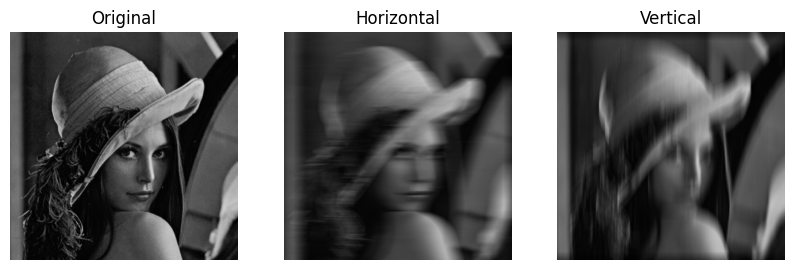

In [ ]:
image = cv2.imread('lena_gray.tif', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10,10))

# Imagen Original
plt.subplot(1,3,1)
plt.axis(False)
plt.title('Original')
plt.imshow(image, cmap='gray', vmin=0, vmax=255)

# Blur horizontal
img_blur, filter_kernel = myBlur(image)
SNR = 10  # dB
img_BlurNoise = noise(img_blur, np.sqrt(np.var(img_blur) * (10**(-SNR/10))))

plt.subplot(1,3,2)
plt.axis(False)
plt.title('Horizontal')
image2 = motion_blur(image, 40, axis=1)
plt.imshow(image2, cmap='gray', vmin=0, vmax=255)

# Blur Verical
plt.subplot(1,3,3)
plt.axis(False)
plt.title('Vertical')
image3 = motion_blur(image, 40, axis=0)
plt.imshow(image3, cmap='gray', vmin=0, vmax=255)
plt.show()

# 5) Regularización + Métodos iterativos

## Regularización

Recordemos el problema visto en el ejemplo de inverse filtering con ruido en donde en ciertos puntos la H(f) se volvía tan pequeña que amplificaba el N(f) tendiendo a infinito.

Las técnicas de Regularización buscan solucionar este problema de mal condicionamiento de problemas. En este informe desarrollaremos la regularización estocastica.

In [ ]:
# Funcion que le agrega ruido con desvio sigma a la imagen
def noise2(image, std):
    noise = np.random.normal(0, std, image.shape)
    return np.clip(image+noise, 0, 255), noise

def stochasticReg(img, img_deg, h, noise):
  Sff = fft.fft2(np.cov(img))
  H = fft.fft2(h)

  num = Sff * np.conjugate(H) * fft.fft2(img_deg)
  den = Sff * np.absolute(H)**2 + fft.fft2(np.cov(noise))

  return fft.ifftshift(fft.ifft2(num / den))

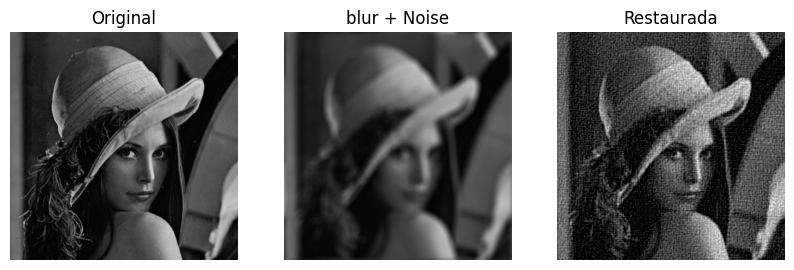

MSE con blur: 292.2510455502702
MSE recuperada: 553.156306626494


In [ ]:
image = cv2.imread('lena_gray.tif', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10,10))

# Imagen Original
plt.subplot(1,3,1)
plt.axis(False)
plt.title('Original')
plt.imshow(image, cmap='gray', vmin=0, vmax=255)

# Con blur + Noise
img_blur, filter_kernel = myBlur(image)
SNR = 30  # dB
img_BlurNoise, noise = noise2(img_blur, np.sqrt(np.var(img_blur) * (10**(-SNR/10))))

plt.subplot(1,3,2)
plt.axis(False)
plt.title('blur + Noise')
plt.imshow(img_BlurNoise, cmap='gray', vmin=0, vmax=255)

# Recuperada con Regularizacion estocastica
image_rec = np.real(stochasticReg(image, img_BlurNoise, filter_kernel, noise))
plt.subplot(1,3,3)
plt.axis(False)
plt.title('Restaurada')
plt.imshow(image_rec, cmap='gray', vmin=0, vmax=255)
plt.show()

print('MSE con blur:', MSE(image, img_blur))
print('MSE recuperada:', MSE(image, image_rec))

## Métodos iterativos

Decidimos aplicar el metodo iterativo de ***Tikhonov-Miller*** el cual consta del siguiente algoritmo de actualización.

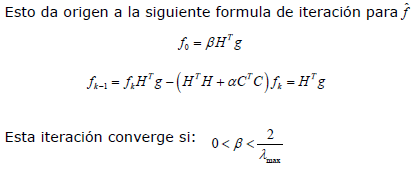

In [ ]:
def TikhonovMiller(img_deg, h, alpha=1e-4):

  # Expandimos el Kernel al tamaño de la foto
  C = np.array([[0,-0.25,0],[-0.25,-1,-0.25],[0,-0.25,0]])
  delta = np.zeros_like(h)
  delta[delta.shape[0]//2, delta.shape[1]//2] = 1
  C = ss.convolve2d(delta, C, mode = "same")

  H = fft2(h)

  aux = H.T*H+alpha*C.T*C # lo del parentesis
  eigenvalores, _= np.linalg.eig(aux)

  betta = (2/ np.max(np.abs(eigenvalores)))*0.5

  f=[]
  f.append(betta*H.T*img_deg)
  f.append(1*H.T*img_deg)

  new_error = 1
  while new_error > 1e-6:
    new_f = f[-1]+ betta* (H.T*img_deg- aux*f[-1])  # Nueva iteración
    f.append(new_f)

    # Diferencia entre la imagen anterior y la actual
    new_error = (np.linalg.norm(f[-1]-f[-2])/np.linalg.norm(f[-2]))**2

  return f[-1]

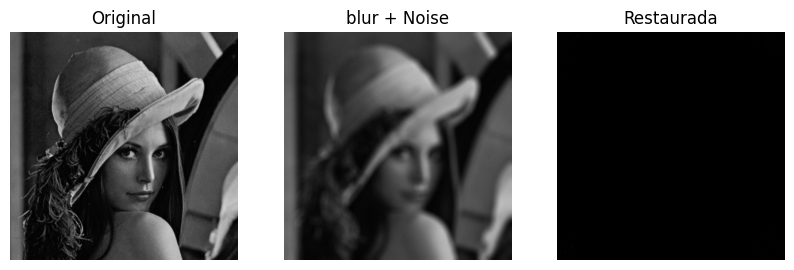

MSE con blur: 54.01197052001953
MSE recuperada: 11716.602956463175


In [ ]:
image = cv2.imread('lena_gray.tif', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10,10))

# Imagen Original
plt.subplot(1,3,1)
plt.axis(False)
plt.title('Original')
plt.imshow(image, cmap='gray', vmin=0, vmax=255)

# Con blur + Noise
img_blur, filter_kernel = myBlur(image)
SNR = 30  # dB
img_BlurNoise, noise = noise2(img_blur, np.sqrt(np.var(img_blur) * (10**(-SNR/10))))

plt.subplot(1,3,2)
plt.axis(False)
plt.title('blur + Noise')
plt.imshow(img_BlurNoise, cmap='gray', vmin=0, vmax=255)

# Recuperada con TikhonovMiller
image_rec = np.real(TikhonovMiller(img_BlurNoise, filter_kernel))
plt.subplot(1,3,3)
plt.axis(False)
plt.title('Restaurada')
plt.imshow(image_rec, cmap='gray', vmin=0, vmax=255)
plt.show()

print('MSE con blur:', MSE(image, img_blur))
print('MSE recuperada:', MSE(image, image_rec))

El ajuste del $\alpha$ es un aspecto crítico de este algoritmo. En nuestro caso no pudimos encontrar un valor aceptable del mismo a pesar de probar valores de distintos ordenes y revisar el algoritmo reiteradas veces. Pudimos debuggear que en la primera iteración ($f_0$) la imagen se vuelve toda negra, lo cual puede ser causado por un desajustado valor de $β$ y con esto concluir lo anteriormente mencionado.

# Eliminación de interferencia

Vemos la imagen y claramente tenemos una interferencia periódica, asi que revisamos el espectro a ver con qué nos escontramos

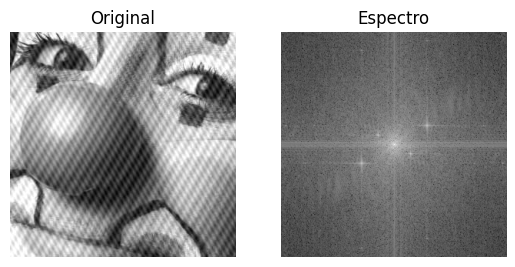

In [ ]:
image = cv2.imread('clown.jpg', cv2.IMREAD_GRAYSCALE)

# Imagen Original
plt.subplot(1,2,1)
plt.axis(False)
plt.title('Original')
plt.imshow(image, cmap='gray', vmin=0, vmax=255)

# Espectro
plt.subplot(1,2,2)
plt.axis(False)
plt.title('Espectro')
image_spect = np.fft.fftshift(np.fft.fft2(image)) # Espectro centrado
spect = np.log(1.0+np.abs(image_spect))           # Escala log para visualizar mejor
plt.imshow(spect, cmap='gray')
plt.show()

En particular, encontramos 4 deltas que probablemente se deban a las componentes de la interferencia periodica. Simplemente las eliminamos del espectro, y obtenemos la imagen restaurada a través de la IFFT

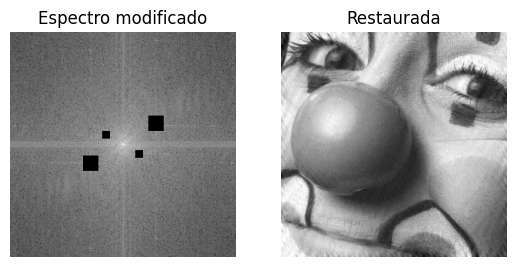

In [ ]:
# Hacemos 0 los valores alrededor de las componentes no deseadas
image_spect[110:130,180:200] = 0
image_spect[162:182,95:115] = 0
image_spect[130:140,120:130] = 0
image_spect[155:165,163:173] = 0

# Mostramos espectro modificado
spect = np.log(1.0+np.abs(image_spect))
plt.subplot(1,2,1)
plt.axis(False)
plt.title('Espectro modificado')
plt.imshow(spect, cmap='gray')

# Volvemos al espacio
img_filt = np.fft.ifft2(np.fft.ifftshift(image_spect)).real

# Imagen restaurada
plt.subplot(1,2,2)
plt.axis(False)
plt.title('Restaurada')
plt.imshow(img_filt, cmap='gray', vmin=0, vmax=255)

plt.show()

Los resultados fueron muy buenos, visualmente casi no se nota la presencia de la interferencia, y la calidad de la imagen no se vio modificada. Otras técnicas de filtrado, si bien lograban eliminar la interferencia, daban resultados borrosos